# 影像分類 with Vision Transformer (ViT)
## 教學目標
- 本教學著重於影像分類任務，使用 [MedMNIST 資料集](https://medmnist.com/)。
- 這份教學的目標是介紹如何以 PyTorch 和 [Transformers](https://github.com/huggingface/transformers) 實作 ViT。

In [1]:
# 0. 檢查是否使用 GPU

import torch
torch.cuda.is_available()

True

In [2]:
# 1. 安裝 MedMNIST

!pip install medmnist

In [3]:
# 2. 載入套件

from tqdm import tqdm # progress bar
# PyTorch 系列
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

from medmnist import PneumoniaMNIST
from transformers import AutoModelForImageClassification
from transformers import AutoImageProcessor
from transformers import ViTModel
from utils import do_test

## 超參數

In [4]:
# 3. 超參數

BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 1e-4
IMAGE_SIZE = 128
PATCH_SIZE = 16
MODEL_NAME = "google/vit-base-patch16-224" # or google/vit-base-patch16-224-in21k

MODEL_TYPE = "custom"
assert MODEL_TYPE in ["HF", "custom"], "IMPLEMENTATION must be either 'HF' or 'custom'"

## 資料集

In [5]:
# 4.1 載入影像測試

tmp = PneumoniaMNIST(split="test", download=True)
print(tmp)

100%|██████████| 4.17M/4.17M [00:07<00:00, 579kB/s]


Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


In [6]:
# 4.2 影像資料前處理準備

image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME, do_rescale=False)
normalize = Normalize(
    mean=[image_processor.image_mean[0]],
    std=[image_processor.image_std[0]],
)
# Data Transform
transform = transforms.Compose(
    [
        transforms.Resize((image_processor.size["height"], image_processor.size["width"])),
        transforms.ToTensor(),
        normalize, # 可以改成你喜歡的
    ]
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [7]:
# 5. Load PneumoniaMNIST
train_raw = PneumoniaMNIST(split="train", download=True, transform=transform)
test_raw = PneumoniaMNIST(split="test", download=True, transform=transform)
train_data, val_data = torch.utils.data.random_split(train_raw, [0.8, 0.2])

In [8]:
print(type(tmp))
tmp[1][0]

<class 'medmnist.dataset.PneumoniaMNIST'>


In [9]:
# 6. 創建 DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_raw, batch_size=BATCH_SIZE, shuffle=False)

## 模型架構

In [10]:
# 7. 模型設置 (Custom)

class CustomViTClassifier(torch.nn.Module):
    def __init__(self, vit_model, num_labels=2):
        super().__init__()
        self.vit = vit_model
        self.config = self.vit.config
        self.classifier = torch.nn.Linear(self.vit.config.hidden_size, num_labels)

    def forward(self, pixel_values):
        # 只接受 pixel_values 參數
        outputs = self.vit(pixel_values=pixel_values)
        logits = self.classifier(outputs.pooler_output)
        return logits

In [11]:
# 8. 模型設置 (HF)

def load_HF_model(model_name, num_labels=2):
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=num_labels,  # PneumoniaMNIST is a binary classification
        ignore_mismatched_sizes=True, # https://github.com/huggingface/transformers/issues/13127
        problem_type="single_label_classification"  # 指定問題類型為單標籤分類
    )
    return model

In [12]:
# 9. 載入 ViT 模型

if MODEL_TYPE == "HF":
    # Load ViT Model
    model = load_HF_model(MODEL_NAME, num_labels=2)
elif MODEL_TYPE == "custom":
    base_model = ViTModel.from_pretrained(MODEL_NAME)
    model = CustomViTClassifier(base_model, num_labels=2)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 觀察位置編碼

In [13]:
# 10. 印出位置編碼維度

pos_embed = base_model.embeddings.position_embeddings
print(pos_embed.shape)

torch.Size([1, 197, 768])


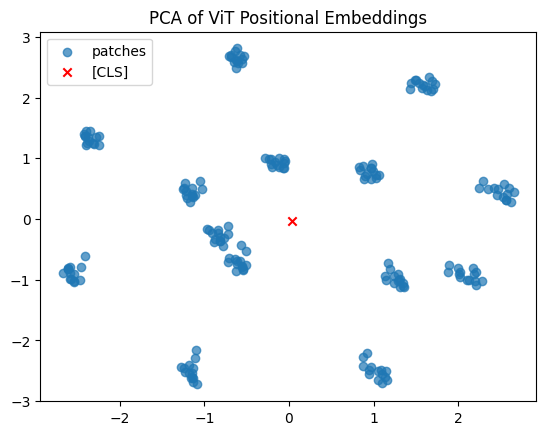

In [14]:
# 11. 畫出二維度的位置編碼

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 去掉 batch 維度
pos_embed_np = pos_embed[0].detach().cpu().numpy()  # shape: (197, 768)

# 用 PCA 將 768 維降到 2 維
pca = PCA(n_components=2)
reduced = pca.fit_transform(pos_embed_np)

# 繪圖：不同顏色標示 CLS token vs patches
plt.scatter(reduced[1:, 0], reduced[1:, 1], label='patches', alpha=0.7)
plt.scatter(reduced[0, 0], reduced[0, 1], color='red', label='[CLS]', marker='x')
plt.legend()
plt.title('PCA of ViT Positional Embeddings')
plt.show()

## 模型訓練

In [15]:
# 12. 訓練前準備

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CustomViTClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_a

In [16]:
# 13. PyTorch training loop

for epoch in range(EPOCHS):
    pbar = tqdm(train_loader)
    pbar.set_description(f"Training epoch [{epoch+1}/{EPOCHS}]")
    model.train()
    for pixel_values, labels in pbar:
        # `pixel_values` 的維度：(batch_size, num_channels, height, width)
        pixel_values = pixel_values.repeat(1, 3, 1, 1)  # 複製通道 3 次
        pixel_values = pixel_values.to(device)
        labels = labels.squeeze().to(device)

        optimizer.zero_grad()

        if MODEL_TYPE == "HF":
            outputs = model(pixel_values=pixel_values, labels=labels).logits
        elif MODEL_TYPE == "custom":
            outputs = model(pixel_values=pixel_values)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss = loss.item())

    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.4f}')

    do_test(val_loader, model, MODEL_TYPE, loss_fn, device, EPOCHS, epoch)

Training epoch [1/3]: 100%|██████████| 118/118 [02:24<00:00,  1.22s/it, loss=0.0155]


Epoch 1/3, Loss: 0.0155


validation epoch [1/3]: 100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


Accuracy: 0.9639 
F1 Score: 0.9531


Training epoch [2/3]: 100%|██████████| 118/118 [02:08<00:00,  1.09s/it, loss=0.00335]


Epoch 2/3, Loss: 0.0034


validation epoch [2/3]: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


Accuracy: 0.9394 
F1 Score: 0.9247


Training epoch [3/3]: 100%|██████████| 118/118 [02:08<00:00,  1.09s/it, loss=0.0295]


Epoch 3/3, Loss: 0.0295


validation epoch [3/3]: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]

Accuracy: 0.9490 
F1 Score: 0.9362
